In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
import re
import seaborn as sns 
from scipy.integrate import odeint

In [212]:
input_dir = '/Users/shristhipatil/Documents/gokhale work/matecopying_simulations/simulation_data/2m_real_BRf2'
data_dir = f'{input_dir}/data'

In [213]:
allfiles = os.listdir(data_dir)
files = sorted(allfiles)

In [210]:
# Read the params file
#params_df = pd.read_csv(f'{input_dir}/params.csv')
#params_dict = dict(zip(params_df["Parameter"], params_df["Value"]))

#y_range_str = params_dict["y_range"]
#c_range_str = params_dict["c_range"]
#param_values_y = np.fromstring(y_range_str.strip("[]"), sep=" ")
#param_values_c = np.fromstring(c_range_str.strip("[]"), sep=" ")
param_values_c = np.around(np.arange(0,1.001,0.01), 2)
param_values_y = np.around(np.arange(0,1.001,0.01), 2)
# lattice of y and gamma values
params_lattice = list(itertools.product(param_values_y, param_values_c))

In [167]:
data = []
for f in files:
    coordinate = params_lattice[files.index(f)]
    df = pd.read_pickle(f'{input_dir}/{f}')

    # average the outcome over all the runs
    x_coord = coordinate[1]
    y_coord = coordinate[0]
    z_value = np.mean([df[df.shape[1]-1][i][1] for i in range(df.shape[0])])
    data.append([x_coord, y_coord, z_value])

#df_save = pd.DataFrame(data, columns=["x", "y", "z"])
#df_save.to_csv("2m_b1_r1.5.csv", index=False)

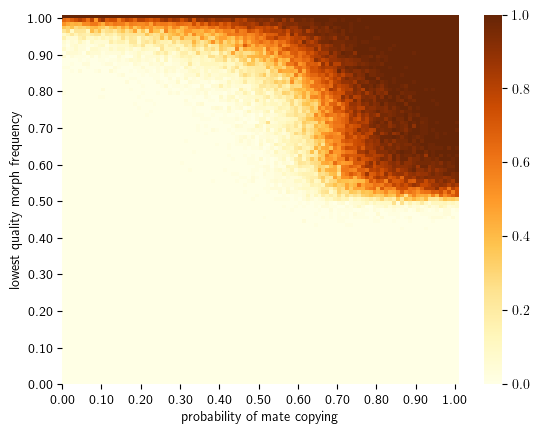

In [214]:
fix_fractions = np.zeros((len(param_values_y), len(param_values_c)))
for y,c in params_lattice:
    f = f'{data_dir}/{float(y):.2f}_{float(c):.2f}.pkl'
    df = pd.read_pickle(f)
    
    # average the outcome over all the runs
    x_idx = np.where(param_values_c==c)[0][0]
    y_idx = np.where(param_values_y==y)[0][0]
    last_gen = np.mean([df[df.shape[1]-1][i][1] for i in range(df.shape[0])])
    fix_fractions[y_idx][x_idx] = last_gen



ax = sns.heatmap(
    fix_fractions,
    xticklabels=False,   # turn off default labels
    yticklabels=False,
    cmap='YlOrBr'
)
ax.invert_yaxis()

# X-axis ticks every 10th value
ax.set_xticks(range(0, len(param_values_c), 10))
ax.set_xticklabels([f"{v:.2f}" for v in param_values_c[::10]])

# Y-axis ticks every 10th value
ax.set_yticks(range(0, len(param_values_y), 10))
ax.set_yticklabels([f"{v:.2f}" for v in param_values_y[::10]])

# Axis labels
ax.set_xlabel("probability of mate copying")
ax.set_ylabel("lowest quality morph frequency")

plt.show()
# sns.heatmap(fix_fractions,xticklabels=param_values_c,yticklabels=param_values_y, cmap='coolwarm')
# plt.gca().invert_yaxis() 
# plt.xlabel("probability of mate copying")
# plt.ylabel('lowest quality morph frequency')
# plt.show()

/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_96349/3084011336.py:24: RuntimeWarning: divide by zero encountered in divide
  A = (1 - c_range) / (a * c_range)
/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_96349/3084011336.py:26: RuntimeWarning: divide by zero encountered in power
  y_fixed = 1 / (k**(1/b) + 1)
/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_96349/3084011336.py:26: RuntimeWarning: invalid value encountered in power
  y_fixed = 1 / (k**(1/b) + 1)


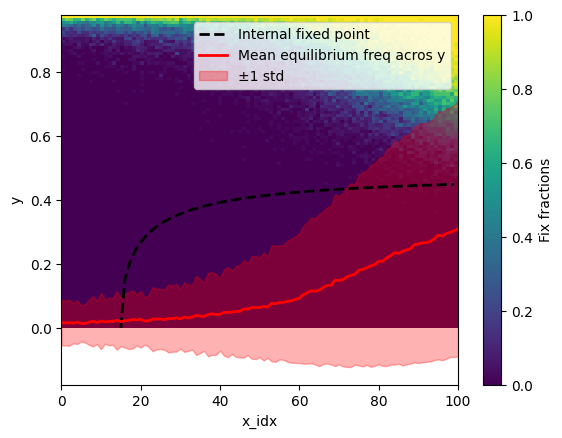

In [67]:
u = 0 # fraction of matings in the training period
q1 = 2 # lower quality morph
q2 = 3 # higher quality morph
a = 2.8 # factor of asymmetry
b = -2 # extent of conformism
r = q2/q1

fix_fractions = np.array(fix_fractions)

# mask rows with y > 0.98
mask = param_values_y <= 0.98
filtered = fix_fractions[mask, :]

# compute mean and std along y-axis (after filtering)
means = filtered.mean(axis=0)
stds = filtered.std(axis=0)

x = np.arange(filtered.shape[1])

c_range = np.linspace(0,1,100)
c_range = np.array(c_range)

# compute internal fixed point
A = (1 - c_range) / (a * c_range)
k = (r + 1) / (A * (r - 1) + r) - 1
y_fixed = 1 / (k**(1/b) + 1)
y_fixed = np.clip(y_fixed, 0, None) 

# overlay this curve in another color (e.g., black dashed)
plt.plot(np.arange(len(c_range)), y_fixed, color='black', linestyle='--', lw=2, label="Internal fixed point")

# plot heatmap of filtered values
plt.imshow(fix_fractions, aspect='auto', origin='lower', cmap='viridis',
           extent=[0, filtered.shape[1]-1, param_values_y[mask].min(), param_values_y[mask].max()])
plt.colorbar(label="Fix fractions")

# overlay ribbon
plt.plot(x, means, color='red', lw=2, label="Mean equilibrium freq acros y")
plt.fill_between(x, means-stds, means+stds, color='red', alpha=0.3, label="±1 std")

plt.xlabel("x_idx")
plt.ylabel("y")
plt.legend()
plt.show()

In [ ]:
u = 0 # fraction of matings in the training period
q1 = 2 # lower quality morph
q2 = 3 # higher quality morph
a = 0.8 # factor of asymmetry
b = 0.5 # extent of conformism
r = q2/q1
#r=4.2
q = np.array([q1,q2])
# range of gamma values for plotting model output
c_range = np.linspace(0.01,1,100)
ct = 2
factor = 1.2

In [204]:
def compute_D(greater_vals, b, factor):
    #if b<0: 
    #    print("Invalid value of b, assuming b=1")
    #    b=1
    y_max = np.max(greater_vals)
    D_lim = min((1/y_max - 1)*sum(greater_vals), sum(greater_vals))
    #D_lim = sum(greater_vals)
    if b>=1:
        y_max = np.max(greater_vals)
        D_max = (1/y_max - 1)*sum(greater_vals)
        #return D_max/factor
        return D_lim/factor
    elif b<1:
        D_min = -sum(greater_vals)
        #return D_min/factor
        return -D_lim/factor

In [145]:
def copying_probabilities(y, b, copying_type=1):
    """ computes switching probabilities based on the type of mate copying: 
    1: continuous copying function
    2: discrete copying function 
    3: custom copying function (more realistic)
    Output: array probabilities of switching to a given morph (may or may not
    depend on the chosen female)"""

    if copying_type==1:
        probs = (y**b)/(y**b + (1-y)**b)
        
    elif copying_type==2:
        if b==1: probs = y # neutral copying
        else: 
            majority = 1/len(y)
            vec = np.array(y)
            
            # partition the frequencies
            greater_idx = np.where(vec > majority)[0]
            equal_idx = np.where(vec == majority)[0]
            less_idx = np.where(vec < majority)[0]

            greater_vals = vec[greater_idx]
            equal_vals = vec[equal_idx]
            less_vals = vec[less_idx]
           
            # compute value of D
            if len(greater_vals)==0: D = 0
            else: D = compute_D(greater_vals, b, factor)
            

            # convert to copying probabilities
            # greater than majority
            greater_vals = greater_vals + (greater_vals/sum(greater_vals))*D
            # less than majority
            inv_y = 1/less_vals
            factors = inv_y / np.sum(inv_y)
            less_vals = less_vals - factors*D
            
            # construct vector of copying probabilities
            probs = np.empty_like(vec)
            probs[greater_idx] = greater_vals
            probs[equal_idx] = equal_vals
            probs[less_idx] = less_vals
        #else: 
        #    print("Invalid value of copying parameter b, assuming neutral copying")
        #    probs = y
    elif copying_type==3:
        majority = 1/len(y)
        vec = np.array(y)
    
        # partition the frequencies 
        greater_idx = np.where(vec > majority)[0]
        equal_idx = np.where(vec == majority)[0]
        less_idx = np.where(vec < majority)[0]

        greater_vals = vec[greater_idx]
        equal_vals = vec[equal_idx]
        less_vals = vec[less_idx]
        
        # compute value of D
        if len(greater_vals)==0: 
            D_conf = 0
            D_anti = 0
        else: 
            D_conf = compute_D(greater_vals, b=2, factor = factor)
            D_anti = compute_D(greater_vals, b=-2, factor = factor)
        
        if len(y)==2:
            threshold = 0.7
        else: # for more than 2 morphs
            threshold = 0.5

        if len(greater_vals)!=0: 
            mask_conf = greater_vals < threshold
            mask_anti = greater_vals >= threshold

            if len(greater_vals[mask_anti])!=0:
                # convert to copying probabilities
                # greater than majority (adjust according to threshold)
                greater_vals[mask_conf] += (greater_vals[mask_conf] / np.sum(greater_vals)) * D_conf
                greater_vals[mask_anti] += (greater_vals[mask_anti] / np.sum(greater_vals)) * D_anti

                # less than majority
                mask_conf2 = less_vals > 1-threshold
                mask_anti2 = less_vals <= 1-threshold
                
                inv_y = np.zeros_like(less_vals, dtype=float)
                mask = np.abs(less_vals) > 1e-5
                inv_y[mask] = 1 / less_vals[mask]

                if np.sum(inv_y) == 0:
                    factors = np.zeros_like(inv_y)
                else:
                    factors = inv_y / np.sum(inv_y)
        
                less_vals[mask_anti2] -= factors*D_anti
                less_vals[mask_conf2] -= factors*D_conf
            else:
                # greater than majority
                greater_vals += (greater_vals/sum(greater_vals))*D_conf
    
                # less than majority
                inv_y = np.zeros_like(less_vals, dtype=float)
                mask = np.abs(less_vals) > 1e-5
                inv_y[mask] = 1 / less_vals[mask]

                if np.sum(inv_y) == 0:
                    factors = np.zeros_like(inv_y)
                else:
                    factors = inv_y / np.sum(inv_y)
        
                less_vals = less_vals - factors*D_conf
    
        # construct vector of copying probabilities
        probs = np.empty_like(vec)
        probs[greater_idx] = greater_vals
        probs[equal_idx] = equal_vals
        probs[less_idx] = less_vals

        probs = np.where(probs > 1e-5, probs, 0)
        #print(probs)           
        #print(y_t)

        #normalize
        prob_sum = sum(probs)
        probs = probs/prob_sum
              
    return probs
    

In [50]:
def copying(y,b):
    return (y**b)/(y**b + (1-y)**b)

In [51]:
def preference(c, y):
    ''' output: array of preference factors for all the morphs; input: gamma, frequency vector'''

    q_sum = sum(q)
    C = copying_probabilities(y,b, copying_type=ct) # copying function
    P = ((1-c)*q/q_sum) + (c*a*C)
    return P

In [107]:
c=0.1
A = (1-c)/(a*c)
constant = -A*(q1 - q2)
print(constant)

#modqualdiff = [abs(q1*preference(c,np.array([x,1-x]))[0] - q2*preference(c,np.array([x,1-x]))[1]) for x in param_values_y]

curve_points = []
resolution = 1000  # Number of points to sample for x
x_values = np.linspace(0, 1, resolution)

vals = []
for x in x_values:
    val = q1*copying_probabilities(np.array([x,1-x]),b, copying_type=ct)[0]-q2*copying_probabilities(np.array([x,1-x]),b, copying_type=ct)[1]
    vals.append(val)
    print(val)
    if np.isclose(val, constant, atol=1e-2):
        curve_points.append(x)

sign_changes = np.where(np.diff(np.sign(vals)))[0]
print(x_values[sign_changes][1])

if len(curve_points)==0:
    #print("No internal fixed points")
    fp = 1
else: 
    fp = np.average(curve_points, axis=0)
    print(fp)



11.249999999999998
nan
-2.999165832499166
-2.998331664998331
-2.997497497497497
-2.996663329996663
-2.9958291624958293
-2.994994994994995
-2.994160827494161
-2.9933266599933264
-2.992492492492492
-2.9916583249916586
-2.9908241574908243
-2.9899899899899895
-2.989155822489156
-2.9883216549883223
-2.987487487487487
-2.9866533199866527
-2.985819152485819
-2.9849849849849854
-2.984150817484151
-2.983316649983317
-2.982482482482482
-2.981648314981648
-2.9808141474808143
-2.9799799799799804
-2.9791458124791457
-2.978311644978312
-2.977477477477477
-2.9766433099766427
-2.9758091424758097
-2.9749749749749745
-2.9741408074741402
-2.9733066399733072
-2.972472472472473
-2.971638304971638
-2.9708041374708043
-2.96996996996997
-2.9691358024691357
-2.9683016349683014
-2.967467467467467
-2.966633299966633
-2.9657991324657993
-2.9649649649649654
-2.9641307974641307
-2.9632966299632963
-2.962462462462462
-2.9616282949616277
-2.9607941274607943
-2.9599599599599604
-2.959125792459126
-2.958291624958292
-2

/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_2256/67077515.py:35: RuntimeWarning: divide by zero encountered in divide
  inv_y = 1/less_vals
/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_2256/67077515.py:36: RuntimeWarning: invalid value encountered in divide
  factors = inv_y / np.sum(inv_y)


In [138]:
print(copying_probabilities(np.array([0.31, 0.69]), -2, 3))
print(copying_probabilities(np.array([0.31, 0.69]), -2, 2))

[0.155 0.845]
[0.465 0.535]


0.6222222222222222


/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_96349/2657213048.py:36: RuntimeWarning: divide by zero encountered in divide
  inv_y = 1/less_vals
/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_96349/2657213048.py:37: RuntimeWarning: invalid value encountered in divide
  factors = inv_y / np.sum(inv_y)


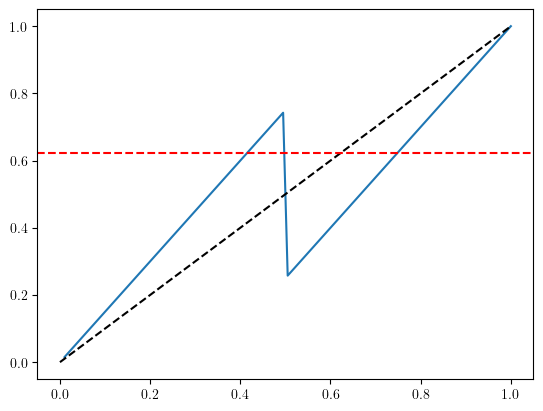

In [206]:
### copying function
c = 0.9
a = 1
A = (1-c)/(a*c)
r = q2/q1
#constant = -A*(q1 - q2)
constant = (A*(r-1)+r)/(r+1)
print(constant)
x_values = np.linspace(0, 1, 100)

vals1 = []
vals2 = []
cps = []
cps2 = []
for x in x_values:
    cp  = copying_probabilities(np.array([x,1-x]),2, copying_type=2)[0]
    cp2 = copying_probabilities(np.array([x,1-x]),-2, copying_type=2)[0]
    cps.append(cp)
    cps2.append(cp2)
    val1 = q1*copying_probabilities(np.array([x,1-x]),2, copying_type=ct)[0]-q2*copying_probabilities(np.array([x,1-x]),2, copying_type=ct)[1]
    val2 = q1*copying_probabilities(np.array([x,1-x]),-2, copying_type=ct)[0]-q2*copying_probabilities(np.array([x,1-x]),-2, copying_type=ct)[1]
    vals1.append(val1)
    vals2.append(val2)

#plt.plot(x_values, cps)
plt.plot(x_values, cps2)
#plt.plot(x_values, x_values)
#plt.plot(x_values, vals1)
#plt.plot(x_values, vals2)
plt.plot(x_values, x_values, linestyle="--", color="k")
plt.axhline(y=constant, linestyle='--', color='r')
plt.show()


/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_1183/67077515.py:35: RuntimeWarning: divide by zero encountered in divide
  inv_y = 1/less_vals
/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_1183/67077515.py:36: RuntimeWarning: invalid value encountered in divide
  factors = inv_y / np.sum(inv_y)


[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.4989979959919839), np.float64(0.4448897795591182), np.float64(0.3727454909819639), np.float64(0.30260521042084165), np.float64(0.23647294589178355), np.float64(0.1723446893787575), np.float64(0.11022044088176351), np.float64(0.052104208416833664), np.floa

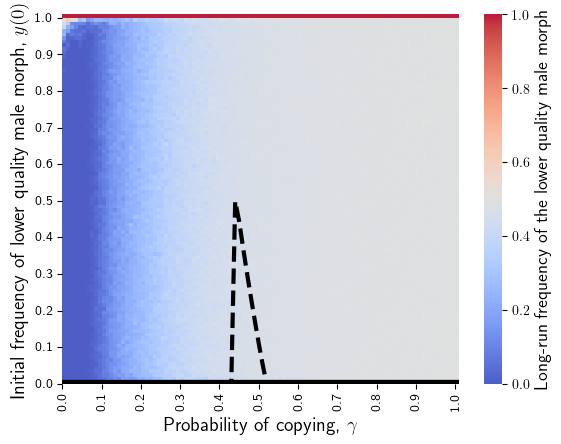

In [307]:
fps = []
for c in c_range:
    A = (u/(1-u) + 1-c)/(a*c)
    constant = -A*(q1 - q2)
    #print(constant)

    #modqualdiff = [abs(q1*preference(c,np.array([x,1-x]))[0] - q2*preference(c,np.array([x,1-x]))[1]) for x in param_values_y]

    curve_points = []
    resolution = 500  # Number of points to sample for x
    x_values = np.linspace(0, 1, resolution)

    vals = []
    for x in x_values:
        #print(q1*copying_probabilities(np.array([x,1-x]),b, copying_type=2)[0]-q2*copying_probabilities(np.array([x,1-x]),b, copying_type=2)[1])
        val = q1*copying_probabilities(np.array([x,1-x]),b, copying_type=ct)[0]-q2*copying_probabilities(np.array([x,1-x]),b, copying_type=ct)[1]
        vals.append(val)
        if np.isclose(val, constant, atol=1e-2):
            curve_points.append(x)

    if len(curve_points)==0:
        #print("No internal fixed points")
        sign_changes = np.where(np.diff(np.sign(vals)))[0]
        #if c<0.45: fp = x_values[sign_changes][2]
        #else: 
        fp = x_values[sign_changes][0]
        #print(x_values[sign_changes])
    else: 
        #fp = np.average(curve_points, axis=0)
        fp = curve_points[-1]
        #print(fp)
    fps.append(fp)

print(fps)
# Create a heatmap
#threshold = np.where(fix_fractions > 0.2, 1, 0)
fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
hm = sns.heatmap(fix_fractions, cmap='coolwarm', alpha=0.9,cbar=True, ax=ax, cbar_kws={'label': 'Long-run frequency of the lower quality male morph'})

cbar = hm.collections[0].colorbar
cbar.set_label('Long-run frequency of the lower quality male morph', fontsize=13)

# Select tick positions for labeling (e.g., 0.1, 0.2, ..., 1.0)
tick_positions_x = np.arange(0, len(param_values_c), 10)  # Every 10th index
tick_positions_y = np.arange(0, len(param_values_y), 10)  # Every 10th index
tick_labels_x = [f"{param_values_c[i]:.1f}" for i in tick_positions_x]  # X tick labels
tick_labels_y = [f"{param_values_y[i]:.1f}" for i in tick_positions_y]  # Y tick labels

# Set ticks and labels
ax.set_xticks(tick_positions_x)
ax.set_xticklabels(tick_labels_x)
ax.set_yticks(tick_positions_y)
ax.set_yticklabels(tick_labels_y)
ax.invert_yaxis()  # Flip y-axis for correct orientation

# Plot curve with rescaled coordinates
curve_x = np.interp(c_range, param_values_c, np.arange(len(param_values_c)))
curve_y = np.interp(fps, param_values_y, np.arange(len(param_values_y)))
ax.plot(curve_x, curve_y, 'k--', linewidth=3)
ax.plot(curve_x, np.repeat(0,100), 'k-', linewidth=6)
#ax.plot(np.array(after_bif)*100, np.repeat(100, len(after_bif)), 'k-', linewidth=3)

# Labels and aspect
ax.set_xlabel(r'Probability of copying, $\gamma$', fontsize=14)
ax.set_ylabel(r'Initial frequency of lower quality male morph, $y(0)$', fontsize=14)
ax.set_aspect('auto')  # Adjust aspect ratio
#plt.savefig("2m_b1_21.5.pdf", format='pdf')
plt.show()


Bifurcation point:  0.4646464646464647


/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_96349/80745572.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  A = (1-c)/(a*c)
/var/folders/mz/q0gq9trj4nx1jdkz52x8x2tr0000gr/T/ipykernel_96349/80745572.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  y = (1/(k+1)-f)/(1-f)


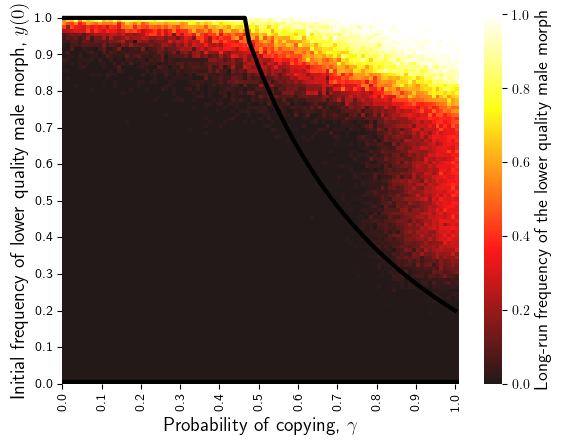

In [207]:
u = 0 # fraction of matings in the training period
q1 = 2 # lower quality morph
q2 = 3 # higher quality morph
a = 0.6 # factor of asymmetry
b = -2 # extent of conformism
r = q2/q1
#r=4.2
f=1/factor

# range of gamma values for plotting model output
c_range = np.linspace(0,1,100)

polymorph = []
bif_pt = 0
is_bif_pt = False

for c in c_range:
    A = (1-c)/(a*c)
    k = (r+1)/(A*(r-1)+r) - 1
    #y =  1/(k**(1/b)+1) # internal fixed point
    #y = (1.2*(q2 - A*(q1-q2))/(q1+q2) - 1)/0.2 
    f = 1/2
    y = (1/(k+1)-f)/(1-f)
    #y = 1/(k+1)
    

    # characterising bifurcation point
    if 1-y>0.00001:
        if is_bif_pt==False:
            print('Bifurcation point: ', c)
            bif_pt = c
            is_bif_pt = True
        
    polymorph.append(y)

after_bif = [x for x in c_range if x>bif_pt]
before_bif = [x for x in c_range if x<=bif_pt]

for i in range(len(before_bif)):
    polymorph[i] = 1

# Create a heatmap
#threshold = np.where(fix_fractions > 0.2, 1, 0)
fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
hm = sns.heatmap(fix_fractions, cmap='hot', alpha=0.9,cbar=True, ax=ax, cbar_kws={'label': 'Long-run frequency of the lower quality male morph'})

cbar = hm.collections[0].colorbar
cbar.set_label('Long-run frequency of the lower quality male morph', fontsize=13)

# Select tick positions for labeling (e.g., 0.1, 0.2, ..., 1.0)
tick_positions_x = np.arange(0, len(param_values_c), 10)  # Every 10th index
tick_positions_y = np.arange(0, len(param_values_y), 10)  # Every 10th index
tick_labels_x = [f"{param_values_c[i]:.1f}" for i in tick_positions_x]  # X tick labels
tick_labels_y = [f"{param_values_y[i]:.1f}" for i in tick_positions_y]  # Y tick labels

# Set ticks and labels
ax.set_xticks(tick_positions_x)
ax.set_xticklabels(tick_labels_x)
ax.set_yticks(tick_positions_y)
ax.set_yticklabels(tick_labels_y)
ax.invert_yaxis()  # Flip y-axis for correct orientation

# Plot curve with rescaled coordinates
curve_x = np.interp(c_range, param_values_c, np.arange(len(param_values_c)))
curve_y = np.interp(polymorph, param_values_y, np.arange(len(param_values_y)))
ax.plot(curve_x, curve_y, 'k-', linewidth=3)
ax.plot(curve_x, np.repeat(0,100), 'k-', linewidth=6)
#ax.plot(np.array(after_bif)*100, np.repeat(100, len(after_bif)), 'k-', linewidth=3)

# Labels and aspect
ax.set_xlabel(r'Probability of copying, $\gamma$', fontsize=14)
ax.set_ylabel(r'Initial frequency of lower quality male morph, $y(0)$', fontsize=14)
ax.set_aspect('auto')  # Adjust aspect ratio
#plt.savefig("2m_b1_21.5.pdf", format='pdf')
plt.show()


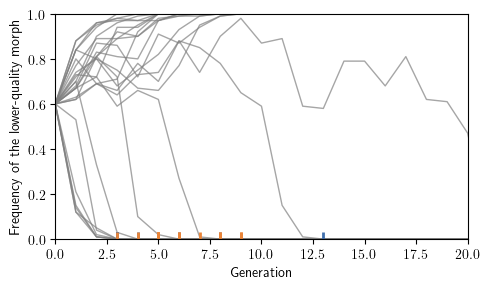

In [296]:
c = 0.65
y0 = 0.6
f = f'{data_dir}/{float(y0):.2f}_{float(c):.2f}.pkl'
df = pd.read_pickle(f)
time_points = df.columns  # or create a list of time points if needed
runs = []

for i in range(len(df)):
    run_values = [df.iloc[i, j][1] for j in range(len(df.columns))]  # Extract the second element
    runs.append(run_values)

# Plotting individual runs
#plt.figure(figsize=(10, 6))
#for run in runs:
#    plt.plot(time_points, run, marker='x', linestyle='-', alpha=0.6)

plt.figure(figsize=(5, 3)) 
for run in runs:
    plt.plot(time_points, run, color="grey", linewidth=1, alpha=0.7)

fixation_times_0 = []
fixation_times_1 = []

for run in runs:
    for t, val in zip(time_points, run):
        if val == 0:
            fixation_times_0.append(t)
            break
        elif val == 1:
            fixation_times_1.append(t)
            break

tick_height = 0.03  # short vertical tick
plt.vlines(fixation_times_0, ymin=0, ymax=tick_height, 
           color="#3F6FAD", linewidth=2)
plt.vlines(fixation_times_1, ymin=0, ymax=tick_height, 
           color="#EA8539", linewidth=2)

#for t in hit_times:
#    plt.scatter(x=t, color="black", linestyle=":", alpha=0.3, linewidth=0.8)

# Calculate and plot the average across all runs
#average_values = np.mean(runs, axis=0)
#plt.plot(time_points, average_values, marker='o', linestyle='-', color='red', label='Average', linewidth=2)

# Plot customization
plt.xlabel('Generation')
plt.ylabel('Frequency of the lower-quality morph')
plt.title('')
plt.ylim([0,1])
plt.xlim([0,20])
#plt.xticks(rotation=45)
#plt.grid(True)
plt.tight_layout()

plt.savefig("../matecopying_simulations/fixed_gamma_freq.pdf", format="pdf")
# Display the plot
plt.show()



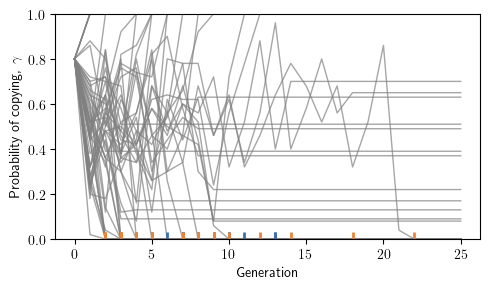

In [203]:
f = f'{data_dir}/{float(y0):.2f}_{float(c):.2f}_gamma.pkl'
df = pd.read_pickle(f)
time_points = df.columns  # or create a list of time points if needed
runs = []

for i in range(len(df)):
    run_values = [df.iloc[i, j] for j in range(len(df.columns))]  # Extract the second element
    runs.append(run_values)

# Plotting individual runs
plt.figure(figsize=(5, 3)) 
for run in runs:
    plt.plot(time_points, run, color="grey", linewidth=1, alpha=0.7)

# Calculate and plot the average across all runs
#average_values = np.mean(runs, axis=0)
#plt.plot(time_points, average_values, marker='o', linestyle='-', color='red', label='Average', linewidth=2)

plt.vlines(fixation_times_0, ymin=0, ymax=tick_height, 
           color="#3F6FAD", linewidth=2)
plt.vlines(fixation_times_1, ymin=0, ymax=tick_height, 
           color="#EA8539", linewidth=2)

# Plot customization
plt.xlabel('Generation')
plt.ylabel(r'Probability of copying, $\gamma$')
plt.title('')
plt.ylim([0,1])
#plt.xticks(rotation=45)
#plt.grid(True)
plt.tight_layout()

plt.savefig("../matecopying_simulations/changing_gamma_gamma.pdf", format="pdf")

# Display the plot
plt.show()



In [47]:
def P(y,q):
    return (1-c)*q/(q1+q2) + a*c*(y**b)/(y**b + (1-y)**b)

def dynamics(y,t):
    dydt = y*(1-y)*(u*((q1**2 - q2**2)/(q1+q2)) + (1-u)*(P(y,q1)*q1 - P(1-y,q2)*q2))
    return dydt


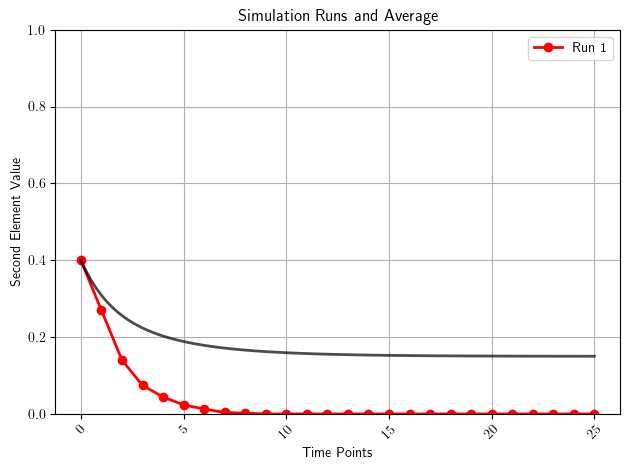

In [282]:
u = 0 # fraction of matings in the training period
q1 = 2 # lower quality morph
q2 = 3 # higher quality morph
a = 0.8 # factor of asymmetry
b = -1 # extent of conformism
r = q2/q1
T = 25

t = np.linspace(0,T,100)
sol = odeint(dynamics, y0, t)


fig, ax = plt.subplots()
plt.plot(time_points, average_values, marker='o', linestyle='-', color='red', label='Average', linewidth=2)

# Plot customization
plt.xlabel('Time Points')
plt.ylabel('Second Element Value')
plt.title('Simulation Runs and Average')
plt.ylim([0,1])
plt.legend(['Run ' + str(i+1) for i in range(len(runs))] + ['Average'])
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()


ax.plot(t, sol[:,0], 'k', alpha=0.7, linewidth=2)


plt.show()
